In [112]:
### 2DO : figure out why partial_pooling gets divergences ###
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pymc3 as pm
import arviz as az

sns.set()


In [113]:
def logit_pure(x):
    return (np.exp(x)) / (1 + np.exp(x))

def logistic_pure(p):
    return np.log(p / (1 - p))

In [114]:
### simulated population that we in reality know nothing about, only thru sampling ###
#np.random.seed(4711)
#np.random.seed(666)
np.random.seed(0XDEADBEEF)

POP_SIZE = 100000 # pop in each cohort #
MAX_CONV_RATE = 0.2


pop_df = pd.DataFrame({'country' : ['SWE','SWE','FIN','FIN','DEN','DEN','NOR','NOR'],
                      'pop' : [POP_SIZE] * 8,
                      'conversions' : np.random.randint(1,int(MAX_CONV_RATE * POP_SIZE),size=8),
                      'age_idx' : [0,1] * 4})

pop_df['conversion_rate'] = pop_df['conversions'] / pop_df['pop']
pop_df['country_idx'],_ = pd.factorize(pop_df['country'])
pop_df.index.name = 'cohort#'
pop_df

,country,pop,conversions,age_idx,conversion_rate,country_idx
cohort#,,,,,,
0,SWE,100000,11993,0,0.11993,0
1,SWE,100000,19426,1,0.19426,0
2,FIN,100000,6970,0,0.06970,1
3,FIN,100000,10339,1,0.10339,1
4,DEN,100000,10066,0,0.10066,2
5,DEN,100000,9246,1,0.09246,2
6,NOR,100000,15379,0,0.15379,3
7,NOR,100000,11354,1,0.11354,3


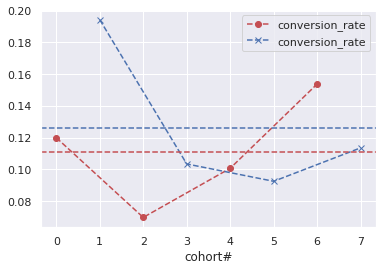

In [115]:
ax = pop_df.loc[pop_df['age_idx']==0].plot(style='ro--',y='conversion_rate')
pop_df.loc[pop_df['age_idx'] == 1].plot(style='bx--',y='conversion_rate',ax=ax)
ax.axhline(pop_df.loc[pop_df['age_idx'] == 0]['conversion_rate'].mean(),color='r',ls='dashed')
ax.axhline(pop_df.loc[pop_df['age_idx'] == 1]['conversion_rate'].mean(),color='b',ls='dashed')

In [116]:
### create a binary representation of conversions to enable sampling ###
def create_pop(df):
    pop_arr = np.zeros((POP_SIZE,len(df)))
    
    i = 0
    for r,c in df.iterrows():
        pop_arr[np.random.choice(np.arange(c['pop']),replace=False,size=c['conversions']),i] = 1
        i +=1
    return pop_arr.T

In [117]:
### binary conversion yes/no for each individual ###
### 1 == conversion, 0 == no conversion ###

sim_pop = pd.DataFrame(create_pop(pop_df)).astype(int)
sim_pop.columns.name = 'individual'
sim_pop.index.name = 'cohort#'
sim_pop

individual,0,1,2,3,4,5,6,7,8,9,...,99990,99991,99992,99993,99994,99995,99996,99997,99998,99999
cohort#,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
6,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,1,0,1,0
7,1,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [118]:
### sample sim_pop ###
MAX_SAMPLE_SIZE = int(0.01 * POP_SIZE) # maximally % of pop are sampled # 

samples = np.zeros((len(sim_pop),2))

i = 0
for r,c in sim_pop.iterrows():
    sample = np.random.choice(c,np.random.randint(0,MAX_SAMPLE_SIZE),replace=False)
    conversions = sample.sum()
    N = len(sample)
    samples[i,0] = conversions
    samples[i,1] = N
    i += 1
    
samples = pd.DataFrame(samples)
samples.columns = ['conversions','sample_size']
samples['conversion_rate'] = samples['conversions'] / samples['sample_size']
samples

,conversions,sample_size,conversion_rate
0,52.0,485.0,0.107216
1,18.0,116.0,0.155172
2,20.0,271.0,0.073801
3,60.0,631.0,0.095087
4,43.0,462.0,0.093074
5,102.0,914.0,0.111597
6,127.0,799.0,0.158949
7,17.0,149.0,0.114094


In [119]:
combined_df = pd.concat([pop_df,samples],axis=1)
combined_df.columns = ['country','pop','pop_conversions','age_idx','pop_conversion_rate','country_idx',
                      'sample_conversions','sample_size','sample_conversion_rate']

combined_df.index.name='cohort#'

combined_df


,country,pop,pop_conversions,age_idx,pop_conversion_rate,country_idx,sample_conversions,sample_size,sample_conversion_rate
cohort#,,,,,,,,,
0,SWE,100000,11993,0,0.11993,0,52.0,485.0,0.107216
1,SWE,100000,19426,1,0.19426,0,18.0,116.0,0.155172
2,FIN,100000,6970,0,0.06970,1,20.0,271.0,0.073801
3,FIN,100000,10339,1,0.10339,1,60.0,631.0,0.095087
4,DEN,100000,10066,0,0.10066,2,43.0,462.0,0.093074
5,DEN,100000,9246,1,0.09246,2,102.0,914.0,0.111597
6,NOR,100000,15379,0,0.15379,3,127.0,799.0,0.158949
7,NOR,100000,11354,1,0.11354,3,17.0,149.0,0.114094


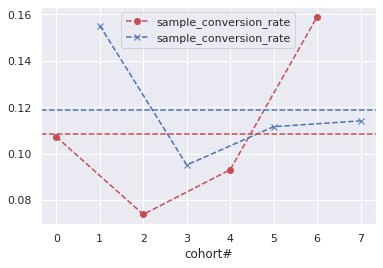

In [120]:
ax = combined_df.loc[combined_df['age_idx']==0].plot(style='ro--',y='sample_conversion_rate')
combined_df.loc[combined_df['age_idx'] == 1].plot(style='bx--',y='sample_conversion_rate',ax=ax)
ax.axhline(combined_df.loc[combined_df['age_idx'] == 0]['sample_conversion_rate'].mean(),color='r',ls='dashed')
ax.axhline(combined_df.loc[combined_df['age_idx'] == 1]['sample_conversion_rate'].mean(),color='b',ls='dashed')

<AxesSubplot:xlabel='cohort#'>

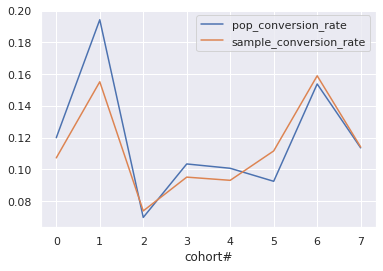

In [121]:
combined_df.plot(y=['pop_conversion_rate','sample_conversion_rate'])

<AxesSubplot:xlabel='cohort#'>

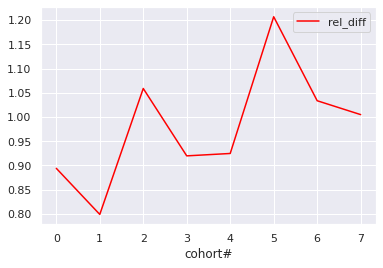

In [122]:
(combined_df['sample_conversion_rate'] / combined_df['pop_conversion_rate']).plot(color='red',label='rel_diff',
                                                                                 legend=True)

0.12968859136650382 -7.164779894951266

conversions         54.875000
sample_size        478.375000
conversion_rate      0.113624
dtype: float64


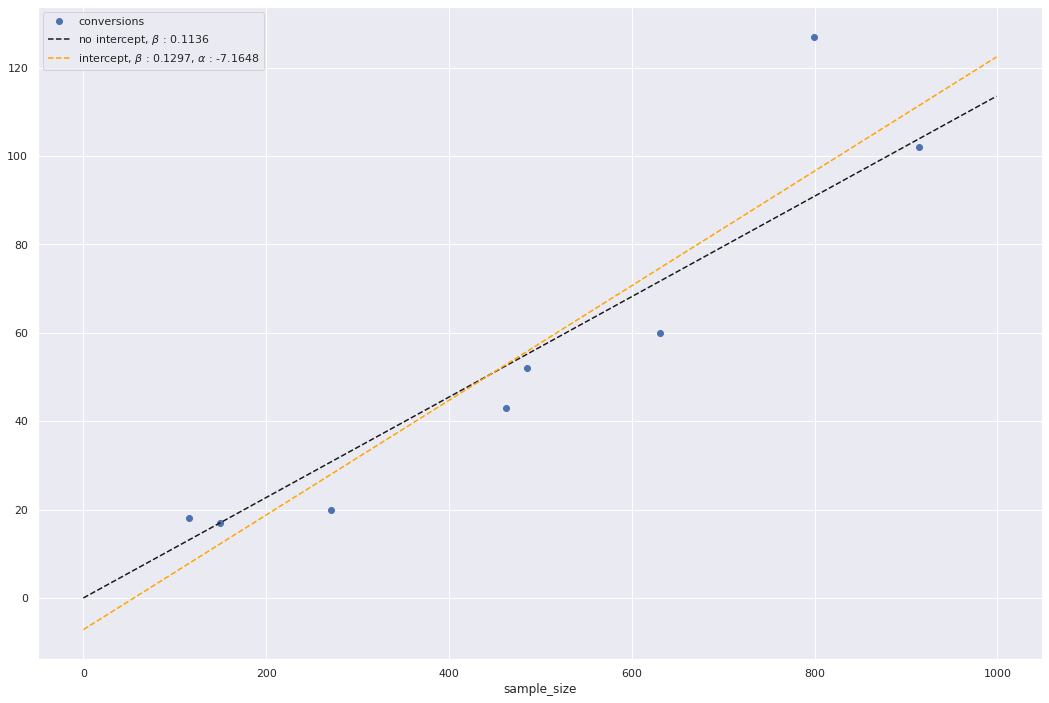

In [123]:
### impact of adding an intercept : without it, intercept is forced to be 0 ###
import scipy.stats as sps

slope,intercept,_,_,_ = sps.linregress(samples['sample_size'], samples['conversions'])
print (slope,intercept)
print ()
print (samples.mean())
ax = samples.plot(x='sample_size',y='conversions',style='o',figsize=(18,12))

X = range(0,1000)

# y = kx (intercept = 0)
ax.plot(X,[X[i] * samples['conversion_rate'].mean() for i in range(len(X))],ls='dashed',color='k',
       label=r'no intercept, $\beta$ : {:.4f}'.format(samples['conversion_rate'].mean()))

# y = kx + m
ax.plot(X,[X[i] * slope + intercept for i in range(len(X))],color='orange',ls='dashed',
       label=r'intercept, $\beta$ : {:.4f}, $\alpha$ : {:.4f}'.format(slope,intercept))
ax.legend(loc='upper left')

In [124]:
print ('avg. rate pop: ',pop_df['conversion_rate'].mean())
print ('avg. rate samples : ',samples['conversion_rate'].mean())
print ('weighted avg. rate pop : ',np.average(pop_df['conversion_rate'],weights=pop_df['pop']))
print ('weighted avg. rate samples : ',np.average(samples['conversion_rate'],weights=samples['sample_size']))


avg. rate pop:  0.11846625
avg. rate samples :  0.11362380284008716
weighted avg. rate pop :  0.11846625
weighted avg. rate samples :  0.11471126208518422


In [125]:
cmp_rates = pd.concat([pop_df['conversion_rate'],samples['conversion_rate']],axis=1)
cmp_rates.columns = ['pop_rate','sample_rate']
cmp_rates['rel_diff'] = cmp_rates['sample_rate'] / cmp_rates['pop_rate']
cmp_rates

,pop_rate,sample_rate,rel_diff
0,0.11993,0.107216,0.893992
1,0.19426,0.155172,0.798787
2,0.06970,0.073801,1.058834
3,0.10339,0.095087,0.919694
4,0.10066,0.093074,0.924633
5,0.09246,0.111597,1.206980
6,0.15379,0.158949,1.033544
7,0.11354,0.114094,1.004879


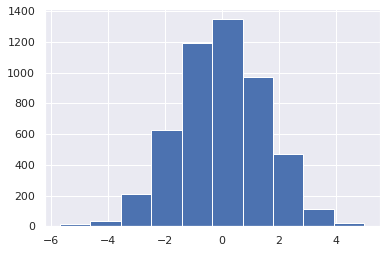

In [126]:
### prior predictive check ###

with pm.Model() as ppc:
    alpha = pm.Normal('alpha',mu=0,sd=1.5)
    prior_predictive = pm.sample_prior_predictive(samples=5000)
    plt.hist(prior_predictive['alpha'])

(array([  5.,  14.,  74., 266., 363., 209.,  58.,   6.,   3.,   2.]),
 array([-7.6323999 , -5.88305265, -4.1337054 , -2.38435814, -0.63501089,
         1.11433636,  2.86368362,  4.61303087,  6.36237812,  8.11172537,
         9.86107263]),
 <BarContainer object of 10 artists>)

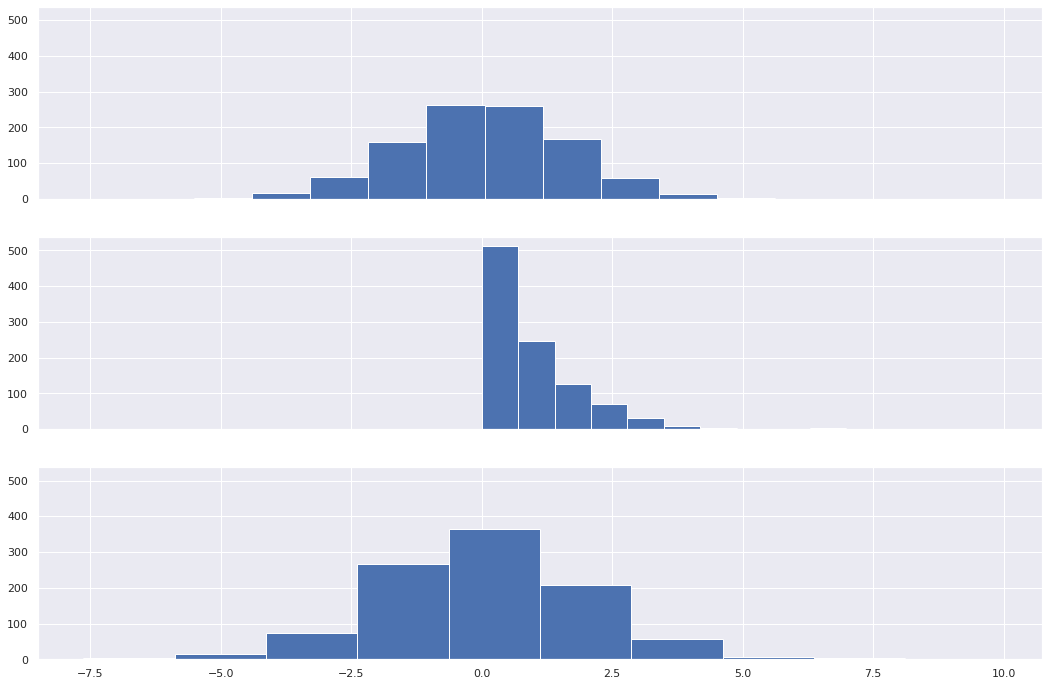

In [127]:
with pm.Model() as ppc2:
    alpha_bar = pm.Normal('alpha_bar',mu=0,sd=1.5)
    sigma = pm.Exponential('sigma',1)
    alpha = pm.Normal('alpha',mu=alpha_bar,sd=sigma)
    
    prior_predictive = pm.sample_prior_predictive(samples=1000)

fig,axes = plt.subplots(3,1,figsize=(18,12),sharex=True,sharey=True)
axes[0].hist(prior_predictive['alpha_bar'])
axes[1].hist(prior_predictive['sigma'])
axes[2].hist(prior_predictive['alpha'])

In [128]:
### no pooling, aggregated, i.e. sum of trials ###

with pm.Model() as no_pool_agg_mdl:
    sigma = pm.Exponential('sigma',1)
    alpha = pm.Normal('alpha',mu=0,sd=sigma)
    
    p_alpha = pm.Deterministic('p_alpha',pm.math.invlogit(alpha))
    
    obs = pm.Binomial('obs',n=samples['sample_size'].sum(),p=pm.math.invlogit(alpha),
                      observed=samples['conversions'].sum())
    
    trace_no_pool_agg_mdl = pm.sample(10000,tune=10000,target_accept=0.99,return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, sigma]


Sampling 2 chains for 10_000 tune and 10_000 draw iterations (20_000 + 20_000 draws total) took 36 seconds.


In [129]:
with no_pool_agg_mdl:
    print (az.summary(trace_no_pool_agg_mdl,hdi_prob=0.89,round_to=5))
    no_pool_agg_mdl_stats = az.summary(trace_no_pool_agg_mdl,hdi_prob=0.89,round_to=5)

            mean       sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  \
alpha   -2.04206  0.05149  -2.12199   -1.95843    0.00051  0.00036   
sigma    1.91448  0.91699   0.71564    3.09830    0.00964  0.00702   
p_alpha  0.11496  0.00523   0.10664    0.12328    0.00005  0.00004   

            ess_bulk    ess_tail    r_hat  
alpha    10230.31585  9240.52837  1.00025  
sigma    10241.23573  9416.51462  1.00001  
p_alpha  10230.31585  9240.52837  1.00025  


In [130]:
np.average(samples['conversion_rate'],weights=samples['sample_size'])

0.11471126208518422

In [131]:
### no pooling,non-aggregated, i.e trial by trial ###

with pm.Model() as no_pool_mdl:
    
    sigma = pm.Exponential('sigma',1)
    alpha = pm.Normal('alpha',mu=0,sd=sigma)
    
    p_alpha = pm.Deterministic('p_alpha',logit_pure(alpha))
    
    obs = pm.Binomial('obs',n=samples['sample_size'],p=logit_pure(alpha),observed=samples['conversions'])
    
    trace_no_pool_mdl = pm.sample(10000,tune=10000,return_inferencedata=False,target_accept=0.99)
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, sigma]


Sampling 2 chains for 10_000 tune and 10_000 draw iterations (20_000 + 20_000 draws total) took 36 seconds.


In [132]:
with no_pool_mdl:
    print (az.summary(trace_no_pool_mdl,hdi_prob=0.89,round_to=5))
    no_pool_mdl_stats = az.summary(trace_no_pool_mdl,hdi_prob=0.89,round_to=5)

            mean       sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  \
alpha   -2.04065  0.05099  -2.12010   -1.95779    0.00052  0.00036   
sigma    1.92994  0.92651   0.75272    3.16347    0.00958  0.00703   
p_alpha  0.11510  0.00519   0.10716    0.12371    0.00005  0.00004   

            ess_bulk    ess_tail    r_hat  
alpha     9783.06999  9352.53793  1.00016  
sigma    10493.99921  9179.65321  1.00000  
p_alpha   9783.06999  9352.53793  1.00018  


In [133]:
np.average(samples['conversion_rate'],weights=samples['sample_size'])

0.11471126208518422

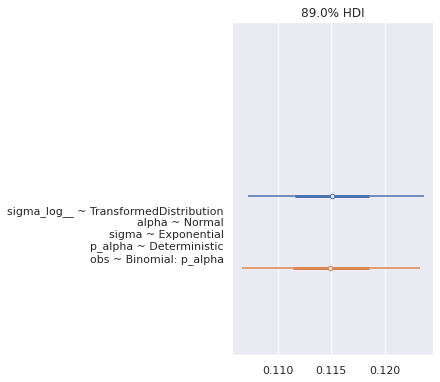

In [134]:
### compare aggregated vs non-aggregated models ###
with no_pool_agg_mdl,no_pool_mdl:
    az.plot_forest(data=[trace_no_pool_mdl,trace_no_pool_agg_mdl],
                   model_names=[no_pool_mdl,no_pool_agg_mdl],var_names=['p_alpha'],combined=True,
                  hdi_prob=0.89)

In [135]:
print ('avg. rate pop : ',pop_df['conversion_rate'].mean())
print ('avg. rate samples : ',samples['conversion_rate'].mean())
print ('weighted avg. rate pop : ',np.average(pop_df['conversion_rate'],weights=pop_df['pop']))
print ('weighted avg. rate samples : ',np.average(samples['conversion_rate'],weights=samples['sample_size']))
print ('Bayesian aggregated mean : ',no_pool_agg_mdl_stats.loc['p_alpha','mean'])
print ('Bayesian non-agg mean : {:.5f}'.format(no_pool_mdl_stats.loc['p_alpha','mean']))

avg. rate pop :  0.11846625
avg. rate samples :  0.11362380284008716
weighted avg. rate pop :  0.11846625
weighted avg. rate samples :  0.11471126208518422
Bayesian aggregated mean :  0.11496
Bayesian non-agg mean : 0.11510


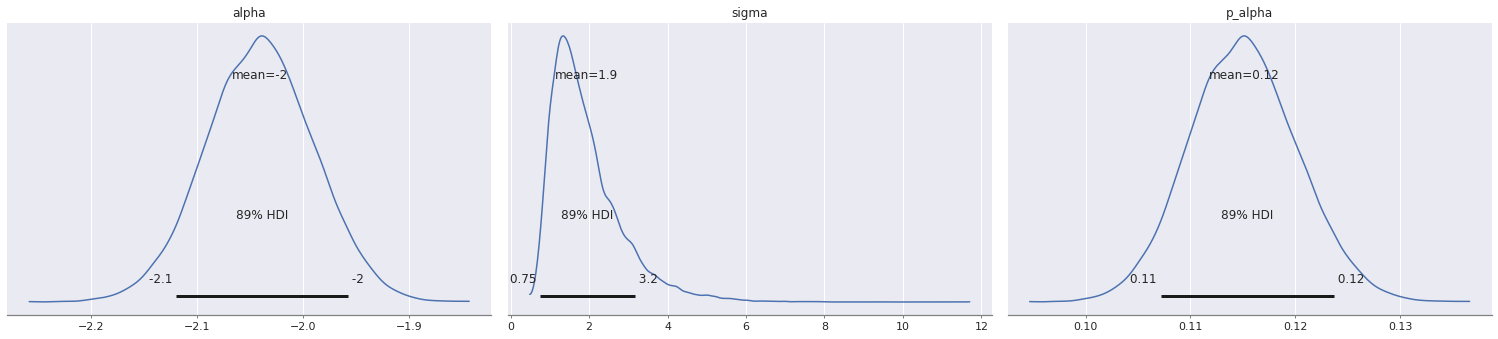

In [136]:
with no_pool_mdl:
    az.plot_posterior(trace_no_pool_mdl,hdi_prob=0.89)

In [137]:
### pooling - full pooling on age only ###

with pm.Model() as pooling_age_mdl:
    alpha = pm.Normal('alpha',mu=0,sd=1.5,shape=2)
    p_alpha = pm.Deterministic('p_alpha',logit_pure(alpha))
    obs = pm.Binomial('obs',n=combined_df['sample_size'],p=logit_pure(alpha[combined_df['age_idx']]),
                      observed=combined_df['sample_conversions']) 
    
    trace_pooling_age_mdl = pm.sample(10000,tune=10000,return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha]


Sampling 2 chains for 10_000 tune and 10_000 draw iterations (20_000 + 20_000 draws total) took 17 seconds.


In [138]:
with pooling_age_mdl:
    print (az.summary(trace_pooling_age_mdl,hdi_prob=0.89,round_to=5))

               mean       sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  \
alpha[0]   -1.99051  0.06807  -2.09964   -1.88093    0.00053  0.00038   
alpha[1]   -2.09906  0.07507  -2.21899   -1.97968    0.00057  0.00041   
p_alpha[0]  0.12039  0.00720   0.10913    0.13228    0.00006  0.00004   
p_alpha[1]  0.10940  0.00730   0.09801    0.12130    0.00006  0.00004   

               ess_bulk     ess_tail    r_hat  
alpha[0]    16468.41735  12871.77080  1.00000  
alpha[1]    17141.11786  13828.80462  1.00009  
p_alpha[0]  16468.41735  12871.77080  0.99999  
p_alpha[1]  17141.11786  13828.80462  1.00009  


In [139]:
### partial pooling - age only ###

with pm.Model() as partial_pooling_age_mdl:
    alpha_bar = pm.Normal('alpha_bar',mu=0,sd=2)
    sigma = pm.Exponential('sigma',2)
    
    alpha = pm.Normal('alpha',mu=alpha_bar,sd=sigma,shape=2)
    p_alpha = pm.Deterministic('p_alpha',logit_pure(alpha))
    p_alpha_bar = pm.Deterministic('p_alpha_bar',logit_pure(alpha_bar))
    
    obs = pm.Binomial('obs',n=combined_df['sample_size'],p=logit_pure(alpha[combined_df['age_idx']]),
                      observed=combined_df['sample_conversions']) 
    
    trace_partial_pooling_age_mdl = pm.sample(1000,tune=1000,
                                              target_accept=0.99,return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, sigma, alpha_bar]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 13 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


                mean       sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  \
alpha_bar   -2.03757  0.23601  -2.34490   -1.75091    0.01597  0.01148   
alpha[0]    -2.01091  0.06656  -2.12005   -1.90881    0.00226  0.00161   
alpha[1]    -2.08882  0.07020  -2.19671   -1.97375    0.00252  0.00178   
sigma        0.23137  0.26516   0.00866    0.50786    0.01523  0.01078   
p_alpha[0]   0.11824  0.00694   0.10716    0.12911    0.00023  0.00017   
p_alpha[1]   0.11038  0.00687   0.09923    0.12113    0.00025  0.00018   
p_alpha_bar  0.11743  0.02493   0.08747    0.14793    0.00166  0.00117   

              ess_bulk   ess_tail    r_hat  
alpha_bar    337.42702  233.05978  1.00101  
alpha[0]     866.83187  951.49675  1.00063  
alpha[1]     772.68033  788.05066  1.00056  
sigma        241.96781  421.06769  1.00286  
p_alpha[0]   866.83187  951.49675  1.00063  
p_alpha[1]   772.68033  788.05066  1.00056  
p_alpha_bar  337.42702  233.05978  1.00082  


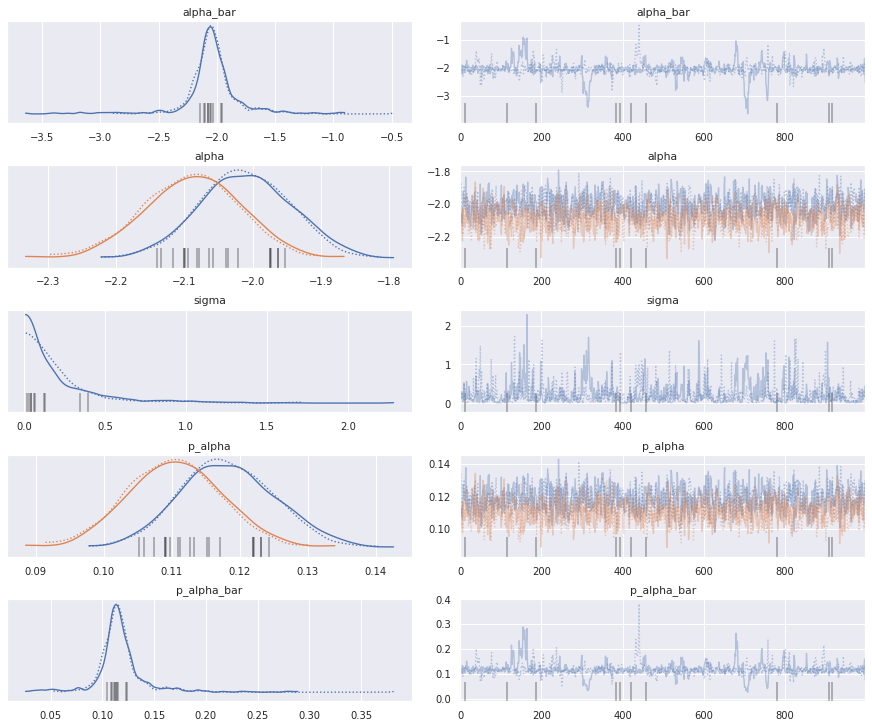

In [140]:
with partial_pooling_age_mdl:
    print (az.summary(data=trace_partial_pooling_age_mdl,hdi_prob=0.89,round_to=5))
    az.plot_trace(trace_partial_pooling_age_mdl)

In [141]:
divergent = trace_partial_pooling_age_mdl['diverging']



/usr/local/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:ylabel='alpha\n1'>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='sigma'>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:xlabel='alpha\n0', ylabel='alpha_bar'>,
        <AxesSubplot:xlabel='alpha\n1'>, <AxesSubplot:xlabel='sigma'>]],
      dtype=object)

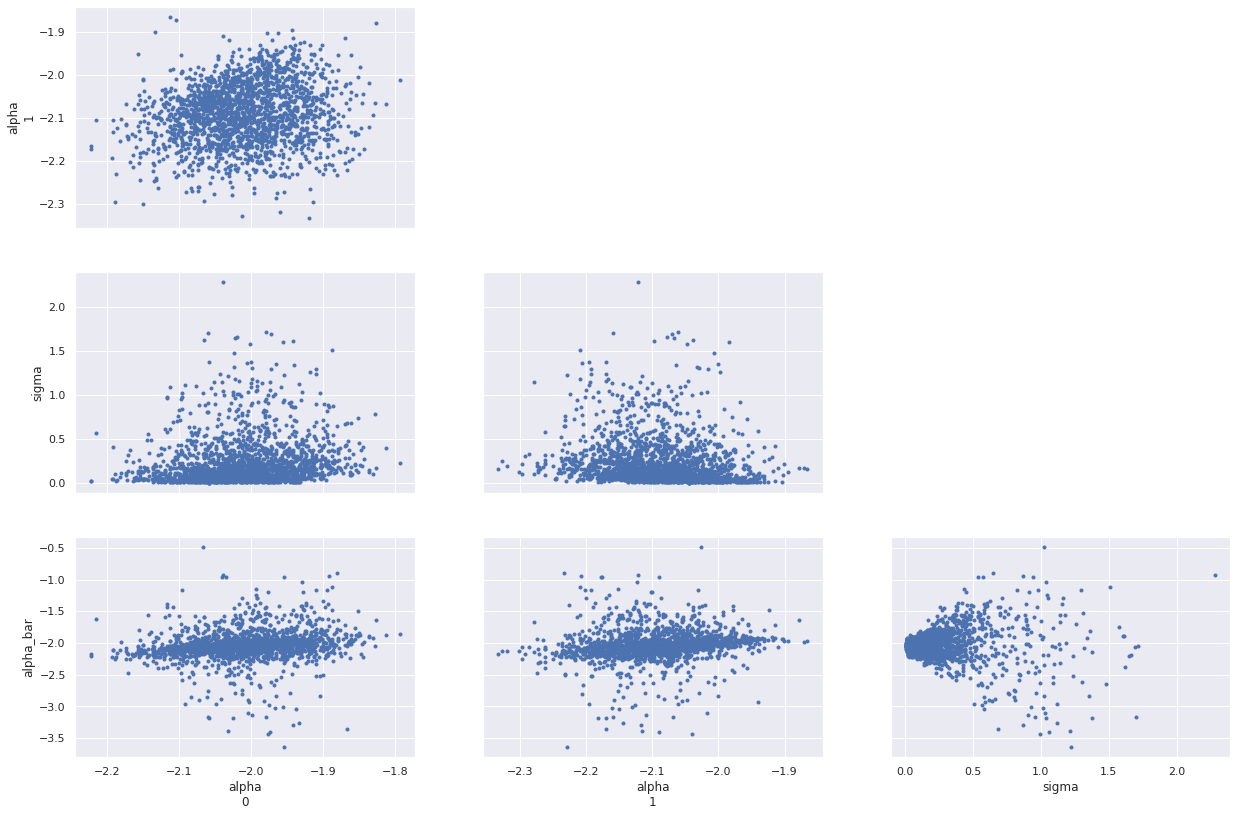

In [142]:
alpha_0_post = trace_partial_pooling_age_mdl.get_values('alpha',combine=True)[:,0]
sigma_post = trace_partial_pooling_age_mdl.get_values('sigma',combine=True)[:]

az.plot_pair(trace_partial_pooling_age_mdl,var_names=['alpha','sigma','alpha_bar'])

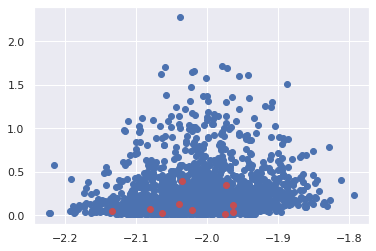

In [143]:
fig,ax = plt.subplots()

ax.scatter(alpha_0_post,sigma_post)
ax.plot(alpha_0_post[divergent],sigma_post[divergent],'o',color='C3')

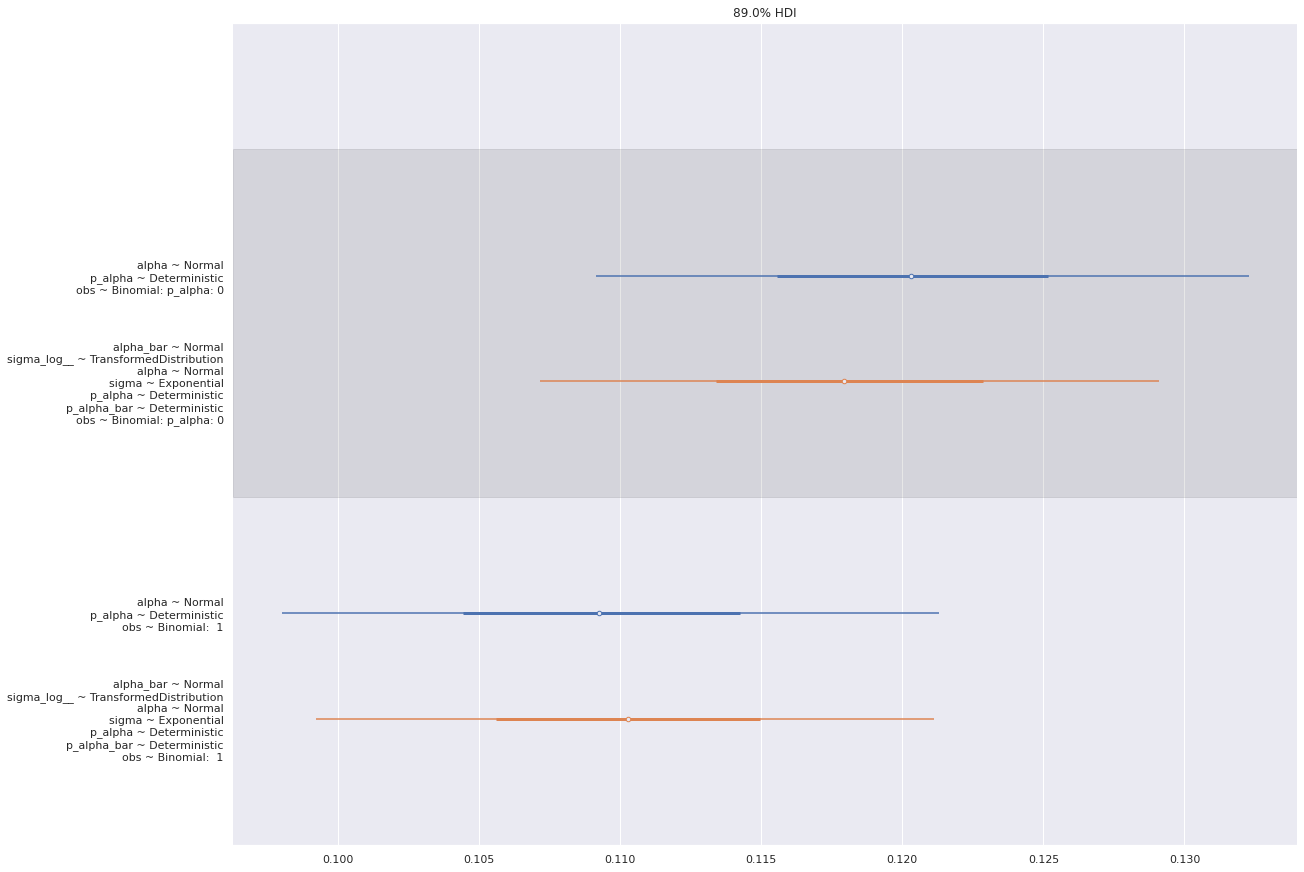

In [144]:
### doing the plot this way is really messy; see below for a better way to plot multiple models ###
with partial_pooling_age_mdl,pooling_age_mdl:
    az.plot_forest(data=[trace_pooling_age_mdl,trace_partial_pooling_age_mdl],
                model_names=[pooling_age_mdl,partial_pooling_age_mdl],var_names='p_alpha',
                hdi_prob=0.89,combined=True,figsize=(18,12))

In [145]:
### non-centered model to solve divergence ###

with pm.Model() as partial_pooling_age_mdl_non_centered:
    ### WAS ###
    #alpha_bar = pm.Normal('alpha_bar',mu=0,sd=2)
    #sigma = pm.Exponential('sigma',2)
    
    # NOW #
    alpha_bar = pm.Normal('alpha_bar',mu=0,sd=2)
    sigma = pm.Normal('sigma',mu=0,sd=1)
    ###    ###
    
    ### WAS ###
    #alpha = pm.Normal('alpha',mu=alpha_bar,sd=sigma,shape=2)
    
    # NOW #
    alpha_offset = pm.Normal('alpha_offset',mu=0,sd=1,shape=2)
    alpha = pm.Deterministic('alpha',alpha_bar + alpha_offset * sigma)
    ###    ###
    
    p_alpha = pm.Deterministic('p_alpha',logit_pure(alpha))
    p_alpha_bar = pm.Deterministic('p_alpha_bar',logit_pure(alpha_bar))
    
    obs = pm.Binomial('obs',n=combined_df['sample_size'],p=logit_pure(alpha[combined_df['age_idx']]),
                      observed=combined_df['sample_conversions']) 
    
    trace_partial_pooling_age_mdl_non_centered = pm.sample(1000,tune=1000,
                                              target_accept=0.99,return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha_offset, sigma, alpha_bar]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 19 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


                    mean       sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  \
alpha_bar       -1.92181  0.42604  -2.48891   -1.32435    0.02829  0.02003   
sigma           -0.09980  0.60177  -1.19209    0.74606    0.05656  0.04010   
alpha_offset[0] -0.01545  0.79019  -1.25445    1.18187    0.04108  0.02907   
alpha_offset[1]  0.04161  0.82012  -1.25524    1.37118    0.04938  0.03495   
alpha[0]        -2.00643  0.06740  -2.11130   -1.89965    0.00162  0.00115   
alpha[1]        -2.08975  0.06983  -2.19603   -1.97595    0.00159  0.00113   
p_alpha[0]       0.11871  0.00706   0.10800    0.13015    0.00017  0.00012   
p_alpha[1]       0.11028  0.00684   0.10011    0.12175    0.00016  0.00011   
p_alpha_bar      0.13517  0.06499   0.07030    0.20137    0.00425  0.00301   

                   ess_bulk    ess_tail    r_hat  
alpha_bar         267.49611   319.13318  1.00551  
sigma             108.37388   242.29086  1.00471  
alpha_offset[0]   369.89879   745.67550  1.00363  
alpha_offset[1]

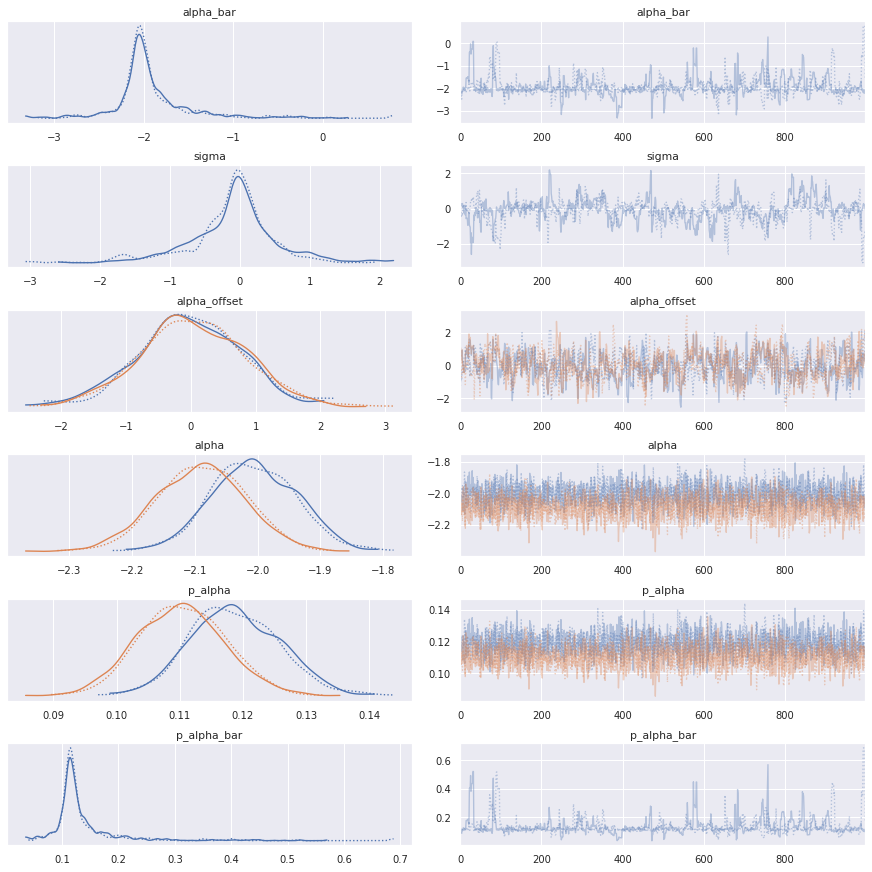

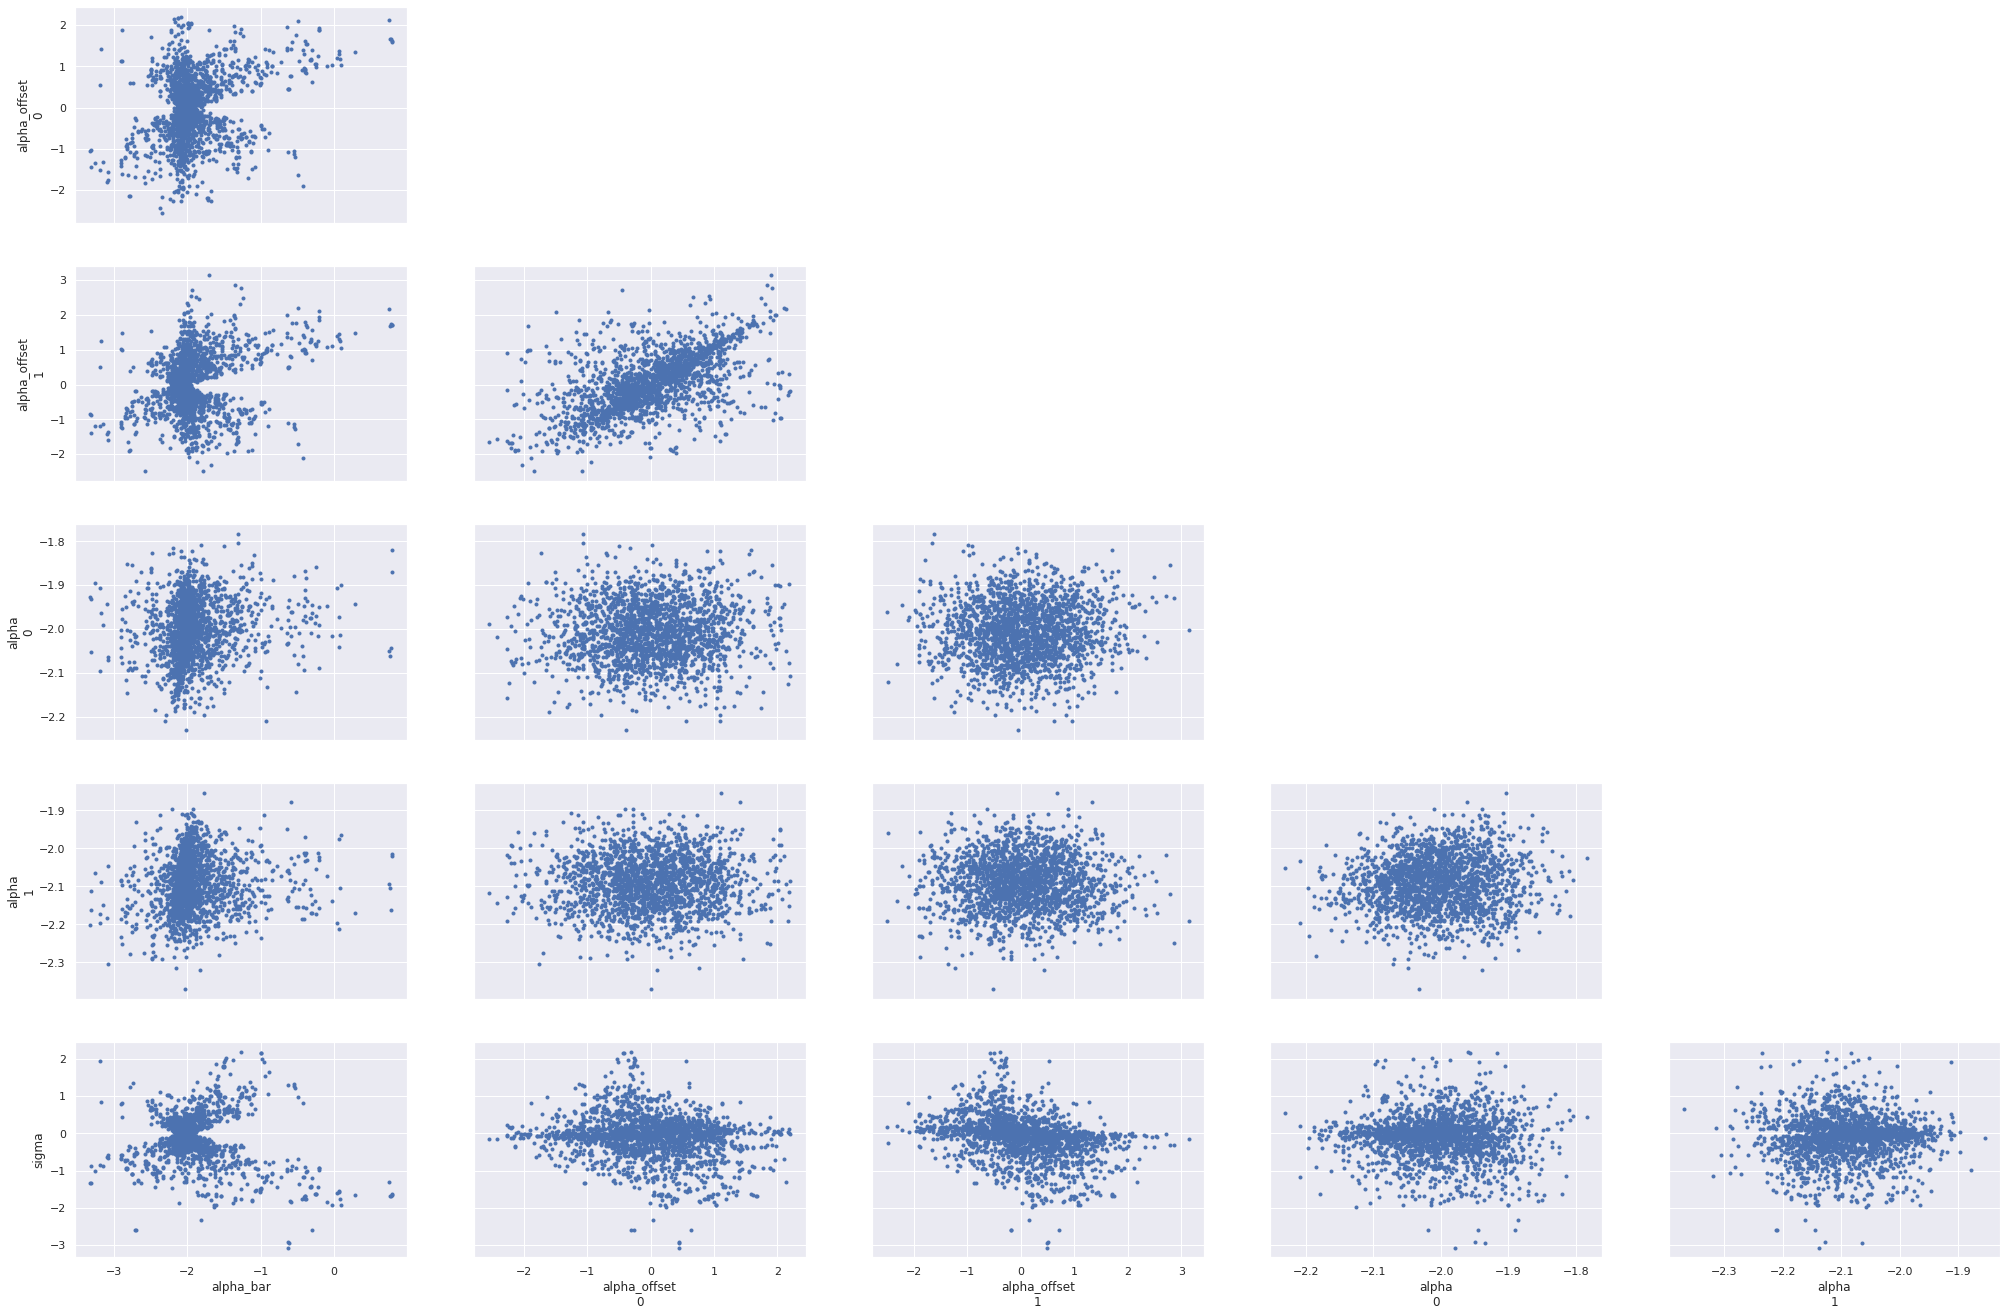

In [146]:
with partial_pooling_age_mdl_non_centered:
    print (az.summary(trace_partial_pooling_age_mdl_non_centered,hdi_prob=0.89,round_to=5))
    az.plot_trace(trace_partial_pooling_age_mdl_non_centered)
    az.plot_pair(trace_partial_pooling_age_mdl_non_centered,var_names=['alpha_bar','alpha_offset','alpha','sigma'])

In [147]:
combined_df

,country,pop,pop_conversions,age_idx,pop_conversion_rate,country_idx,sample_conversions,sample_size,sample_conversion_rate
cohort#,,,,,,,,,
0,SWE,100000,11993,0,0.11993,0,52.0,485.0,0.107216
1,SWE,100000,19426,1,0.19426,0,18.0,116.0,0.155172
2,FIN,100000,6970,0,0.06970,1,20.0,271.0,0.073801
3,FIN,100000,10339,1,0.10339,1,60.0,631.0,0.095087
4,DEN,100000,10066,0,0.10066,2,43.0,462.0,0.093074
5,DEN,100000,9246,1,0.09246,2,102.0,914.0,0.111597
6,NOR,100000,15379,0,0.15379,3,127.0,799.0,0.158949
7,NOR,100000,11354,1,0.11354,3,17.0,149.0,0.114094


In [148]:
### weighted avg of samples gets closest to Bayes mean ###

print (combined_df.loc[combined_df['age_idx'] == 0][['pop_conversion_rate','sample_conversion_rate']].mean())
print (combined_df.loc[combined_df['age_idx'] == 1][['pop_conversion_rate','sample_conversion_rate']].mean())

conv_0 = combined_df.loc[combined_df['age_idx'] == 0][['pop_conversion_rate','sample_conversion_rate']]
weights_0 = combined_df.loc[combined_df['age_idx'] == 0]['sample_size'] 

conv_1 = combined_df.loc[combined_df['age_idx'] == 1][['pop_conversion_rate','sample_conversion_rate']]
weights_1 = combined_df.loc[combined_df['age_idx'] == 1]['sample_size']

print ('weighted sample avg 0 : ',np.average(conv_0['sample_conversion_rate'],weights=weights_0))
print ('weighted sample avg 1 : ',np.average(conv_1['sample_conversion_rate'],weights=weights_1))
print ()

print ('weighted_pop_avg_0 : ',np.average(conv_0['pop_conversion_rate'],weights=weights_0))
print ('weighted_pop_avg_1 : ',np.average(conv_1['pop_conversion_rate'],weights=weights_1))
print()

print ('Bayes full pool mean : ',trace_pooling_age_mdl['p_alpha'].mean(axis=0))
print ('Bayes partial pool mean : ',trace_partial_pooling_age_mdl['p_alpha'].mean(axis=0))

pop_conversion_rate       0.11102
sample_conversion_rate    0.10826
dtype: float64
pop_conversion_rate       0.125912
sample_conversion_rate    0.118988
dtype: float64
weighted sample avg 0 :  0.11998016856717898
weighted sample avg 1 :  0.10883977900552486

weighted_pop_avg_0 :  0.12218040654437283
weighted_pop_avg_1 :  0.10452991712707183

Bayes full pool mean :  [0.12038884 0.10940172]
Bayes partial pool mean :  [0.11823793 0.11037619]


In [149]:
combined_df

,country,pop,pop_conversions,age_idx,pop_conversion_rate,country_idx,sample_conversions,sample_size,sample_conversion_rate
cohort#,,,,,,,,,
0,SWE,100000,11993,0,0.11993,0,52.0,485.0,0.107216
1,SWE,100000,19426,1,0.19426,0,18.0,116.0,0.155172
2,FIN,100000,6970,0,0.06970,1,20.0,271.0,0.073801
3,FIN,100000,10339,1,0.10339,1,60.0,631.0,0.095087
4,DEN,100000,10066,0,0.10066,2,43.0,462.0,0.093074
5,DEN,100000,9246,1,0.09246,2,102.0,914.0,0.111597
6,NOR,100000,15379,0,0.15379,3,127.0,799.0,0.158949
7,NOR,100000,11354,1,0.11354,3,17.0,149.0,0.114094


In [150]:
print (combined_df.loc[combined_df['age_idx'] == 0]['sample_conversion_rate'].mean())
print (combined_df.loc[combined_df['age_idx'] == 1]['sample_conversion_rate'].mean())

0.10825987794591391
0.11898772773426042


array([<AxesSubplot:title={'center':'89.0% HDI'}>], dtype=object)

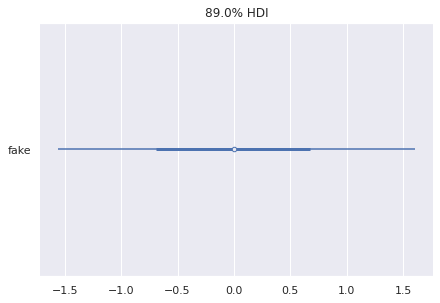

In [151]:
### example to plot any random distribution ###
az.plot_forest({'fake' : sps.norm.rvs(0,1,10000)},hdi_prob=0.89)

/usr/local/lib64/python3.8/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


array([<AxesSubplot:title={'center':'89.0% HDI'}>], dtype=object)

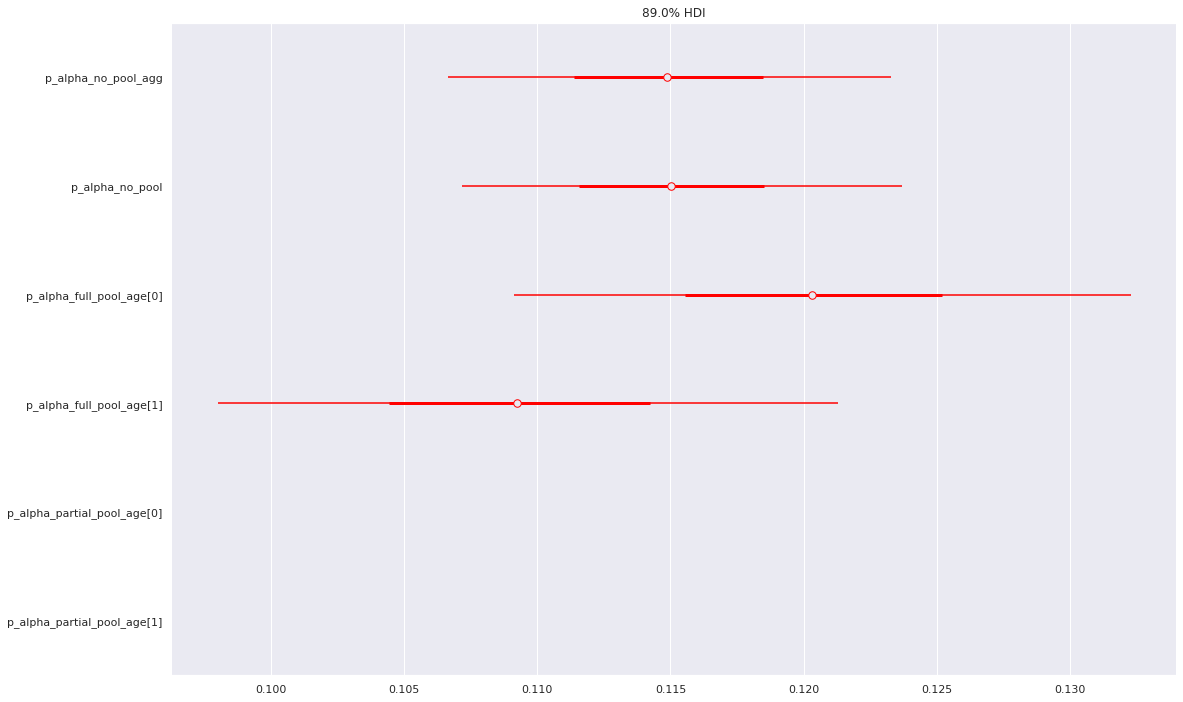

In [152]:
### forest plot with several models ###
fig,ax = plt.subplots(figsize=(18,12))
az.plot_forest({'p_alpha_no_pool_agg' : trace_no_pool_agg_mdl['p_alpha'],
               'p_alpha_no_pool' : trace_no_pool_mdl['p_alpha'],
               'p_alpha_full_pool_age[0]' : trace_pooling_age_mdl['p_alpha'][:,0],
               'p_alpha_full_pool_age[1]' : trace_pooling_age_mdl['p_alpha'][:,1],
               'p_alpha_partial_pool_age[0]' : trace_partial_pooling_age_mdl['p_alpha'][:,0],
               'p_alpha_partial_pool_age[1]' : trace_partial_pooling_age_mdl['p_alpha'][:,1]},
               hdi_prob=0.89,ax=ax,colors=['red'],
              markersize=10)


In [153]:
### A/B test on fully pooled on age ###

coords = {'age' : ['young','old']}

with pm.Model(coords=coords) as a_b_full_pool_age:
    sigma = pm.Exponential('sigma',1)
    alpha = pm.Normal('alpha',mu=0,sd=sigma,dims='age')
    
    p_alpha = pm.Deterministic('p_alpha',pm.math.invlogit(alpha),dims='age')
    
    ### 1(old) == treatment, 0(young) == control ###
    rel_diff = pm.Deterministic('rel_diff',(p_alpha[1] / p_alpha[0]) - 1 )
    abs_diff = pm.Deterministic('abs_diff',p_alpha[1] - p_alpha[0])
    
    obs = pm.Binomial('obs',n=combined_df['sample_size'],p=pm.math.invlogit(alpha[combined_df['age_idx']]),
                     observed=combined_df['sample_conversions'])
    
    trace_a_b_full_pool_age = pm.sample(10000,tune=10000,return_inferencedata=False,
                                       target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, sigma]


Sampling 2 chains for 10_000 tune and 10_000 draw iterations (20_000 + 20_000 draws total) took 31 seconds.


In [154]:
with a_b_full_pool_age:
    print (pm.summary(trace_a_b_full_pool_age,hdi_prob=0.89,round_to=5))

               mean       sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  \
alpha[0]   -1.99109  0.06884  -2.10272   -1.88261    0.00052  0.00037   
alpha[1]   -2.10068  0.07548  -2.22415   -1.98274    0.00058  0.00041   
sigma       2.01648  0.80775   0.91948    3.08409    0.00693  0.00525   
p_alpha[0]  0.12033  0.00728   0.10862    0.13187    0.00005  0.00004   
p_alpha[1]  0.10925  0.00734   0.09760    0.12103    0.00006  0.00004   
rel_diff   -0.08883  0.08217  -0.21903    0.04091    0.00062  0.00049   
abs_diff   -0.01109  0.01027  -0.02742    0.00532    0.00008  0.00006   

               ess_bulk     ess_tail    r_hat  
alpha[0]    17588.84647  13553.25118  1.00009  
alpha[1]    17141.36673  12994.54589  1.00012  
sigma       16618.36246  12474.00059  1.00024  
p_alpha[0]  17588.84647  13553.25118  1.00009  
p_alpha[1]  17141.36673  12994.54589  1.00010  
rel_diff    17719.52202  13295.60655  1.00008  
abs_diff    17786.08724  13255.80531  1.00008  


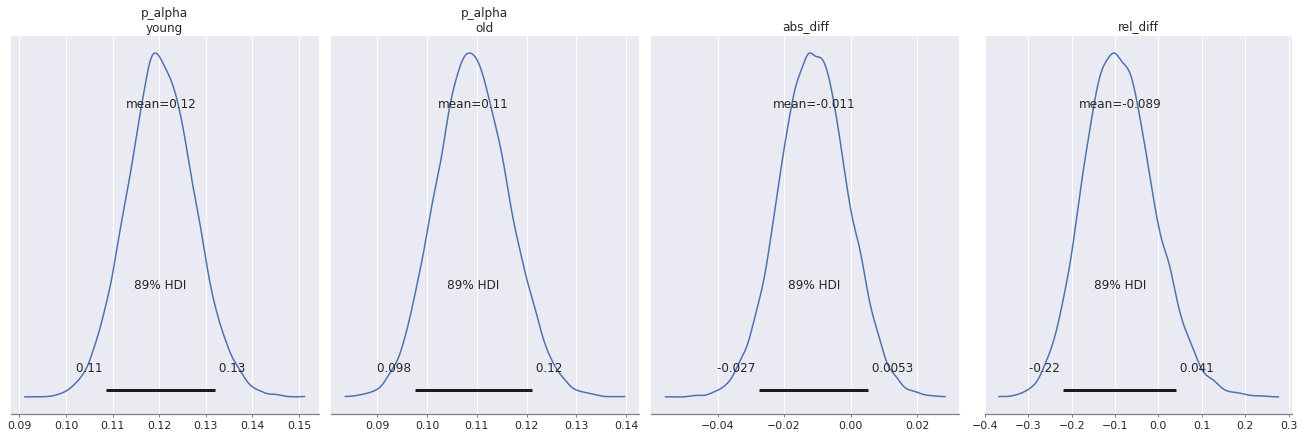

In [155]:
with a_b_full_pool_age:
    az.plot_posterior(data=trace_a_b_full_pool_age,hdi_prob=0.89,
                      var_names=['p_alpha','abs_diff','rel_diff'],figsize=(18,6))

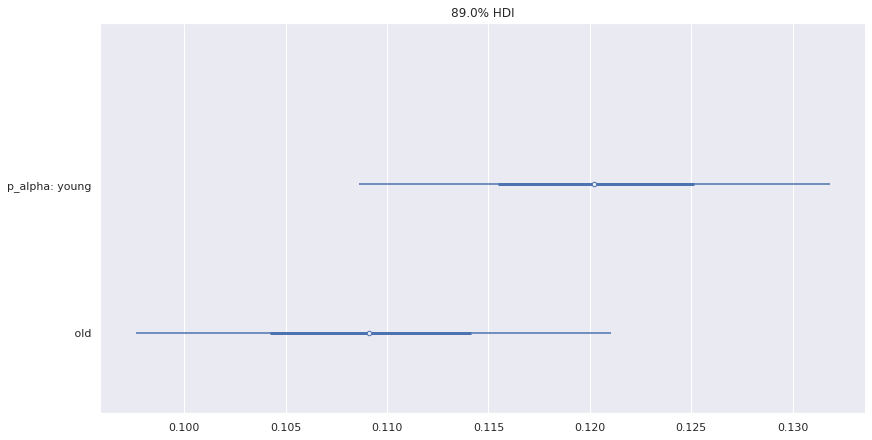

In [156]:
with a_b_full_pool_age:
    az.plot_forest(data=trace_a_b_full_pool_age,var_names=['p_alpha'],hdi_prob=0.89,
                   combined=True,figsize=(12,6))

In [157]:
a_b_full_pool_idata = az.from_pymc3(trace=trace_a_b_full_pool_age,model=a_b_full_pool_age,coords=coords)
a_b_full_pool_idata.posterior.coords

Coordinates:
  * chain    (chain) int64 0 1
  * draw     (draw) int64 0 1 2 3 4 5 6 7 ... 9993 9994 9995 9996 9997 9998 9999
  * age      (age) <U5 'young' 'old'

In [158]:
a_b_full_pool_idata

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [159]:
with a_b_full_pool_age:
    a_b_full_pool_stats = az.summary(trace_a_b_full_pool_age,hdi_prob=0.89,round_to=6)
    
a_b_full_pool_stats

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],-1.991086,0.068842,-2.102722,-1.882608,0.000520,0.000368,17588.846472,13553.251176,1.000089
alpha[1],-2.100682,0.075476,-2.224152,-1.982740,0.000577,0.000409,17141.366726,12994.545891,1.000116
sigma,2.016481,0.807746,0.919481,3.084091,0.006928,0.005250,16618.362464,12474.000591,1.000242
p_alpha[0],0.120332,0.007276,0.108620,0.131869,0.000055,0.000039,17588.846472,13553.251176,1.000088
p_alpha[1],0.109247,0.007336,0.097602,0.121027,0.000056,0.000040,17141.366726,12994.545891,1.000104
rel_diff,-0.088829,0.082172,-0.219025,0.040914,0.000617,0.000490,17719.522021,13295.606554,1.000077
abs_diff,-0.011085,0.010272,-0.027415,0.005321,0.000077,0.000062,17786.087236,13255.805307,1.000076


In [160]:
fully_pooled_tot = combined_df.groupby('age_idx')[['sample_conversions','sample_size']].sum()
fully_pooled_tot['sample_conversions'] / fully_pooled_tot['sample_size']

age_idx
0    0.11998
1    0.10884
dtype: float64

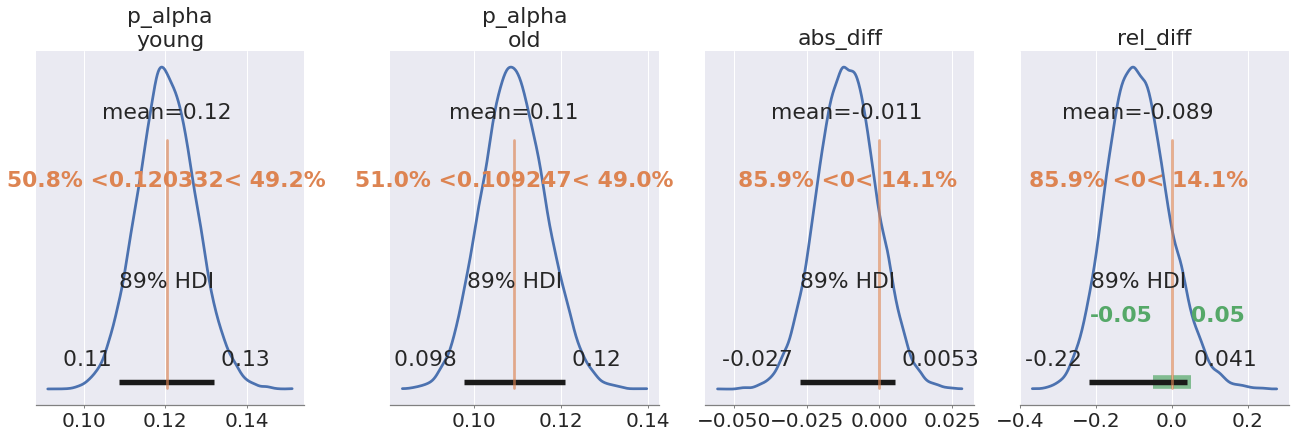

In [161]:
### old is treatment grp, young is control group ###

with a_b_full_pool_age:
    az.plot_posterior(data=a_b_full_pool_idata,coords=coords,
                      var_names=['p_alpha','abs_diff','rel_diff'],hdi_prob=0.89,
                     figsize=(18,6),
                      
                      ### to assign different ref_vals to different var_names ###
                      ### dict of param_names : list of dicts for each dimension element ###
                      ref_val={'p_alpha' : [
                                            {'age': 'young' , 'ref_val' : a_b_full_pool_stats.loc['p_alpha[0]','mean']},
                                            {'age' : 'old', 'ref_val' : a_b_full_pool_stats.loc['p_alpha[1]','mean']}
                                            ],
                                'abs_diff' : [{'ref_val' : 0}],
                                'rel_diff' : [{'ref_val' : 0}]},
                      textsize=20,
                     rope={'rel_diff' :[{'rope' : [-0.05,0.05]}]}) # equal if rel_diff <= +- 5% #

In [162]:
combined_df

,country,pop,pop_conversions,age_idx,pop_conversion_rate,country_idx,sample_conversions,sample_size,sample_conversion_rate
cohort#,,,,,,,,,
0,SWE,100000,11993,0,0.11993,0,52.0,485.0,0.107216
1,SWE,100000,19426,1,0.19426,0,18.0,116.0,0.155172
2,FIN,100000,6970,0,0.06970,1,20.0,271.0,0.073801
3,FIN,100000,10339,1,0.10339,1,60.0,631.0,0.095087
4,DEN,100000,10066,0,0.10066,2,43.0,462.0,0.093074
5,DEN,100000,9246,1,0.09246,2,102.0,914.0,0.111597
6,NOR,100000,15379,0,0.15379,3,127.0,799.0,0.158949
7,NOR,100000,11354,1,0.11354,3,17.0,149.0,0.114094


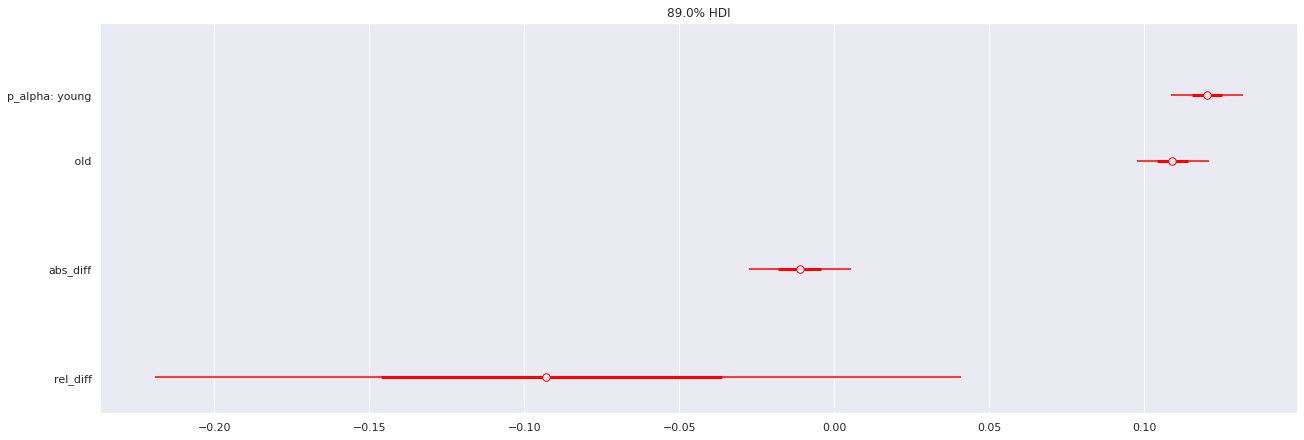

In [163]:
with a_b_full_pool_age:
    az.plot_forest(data=a_b_full_pool_idata,coords=coords,
                      var_names=['p_alpha','abs_diff','rel_diff'],hdi_prob=0.89,
                     figsize=(18,6),combined=True,colors='red',markersize=10)

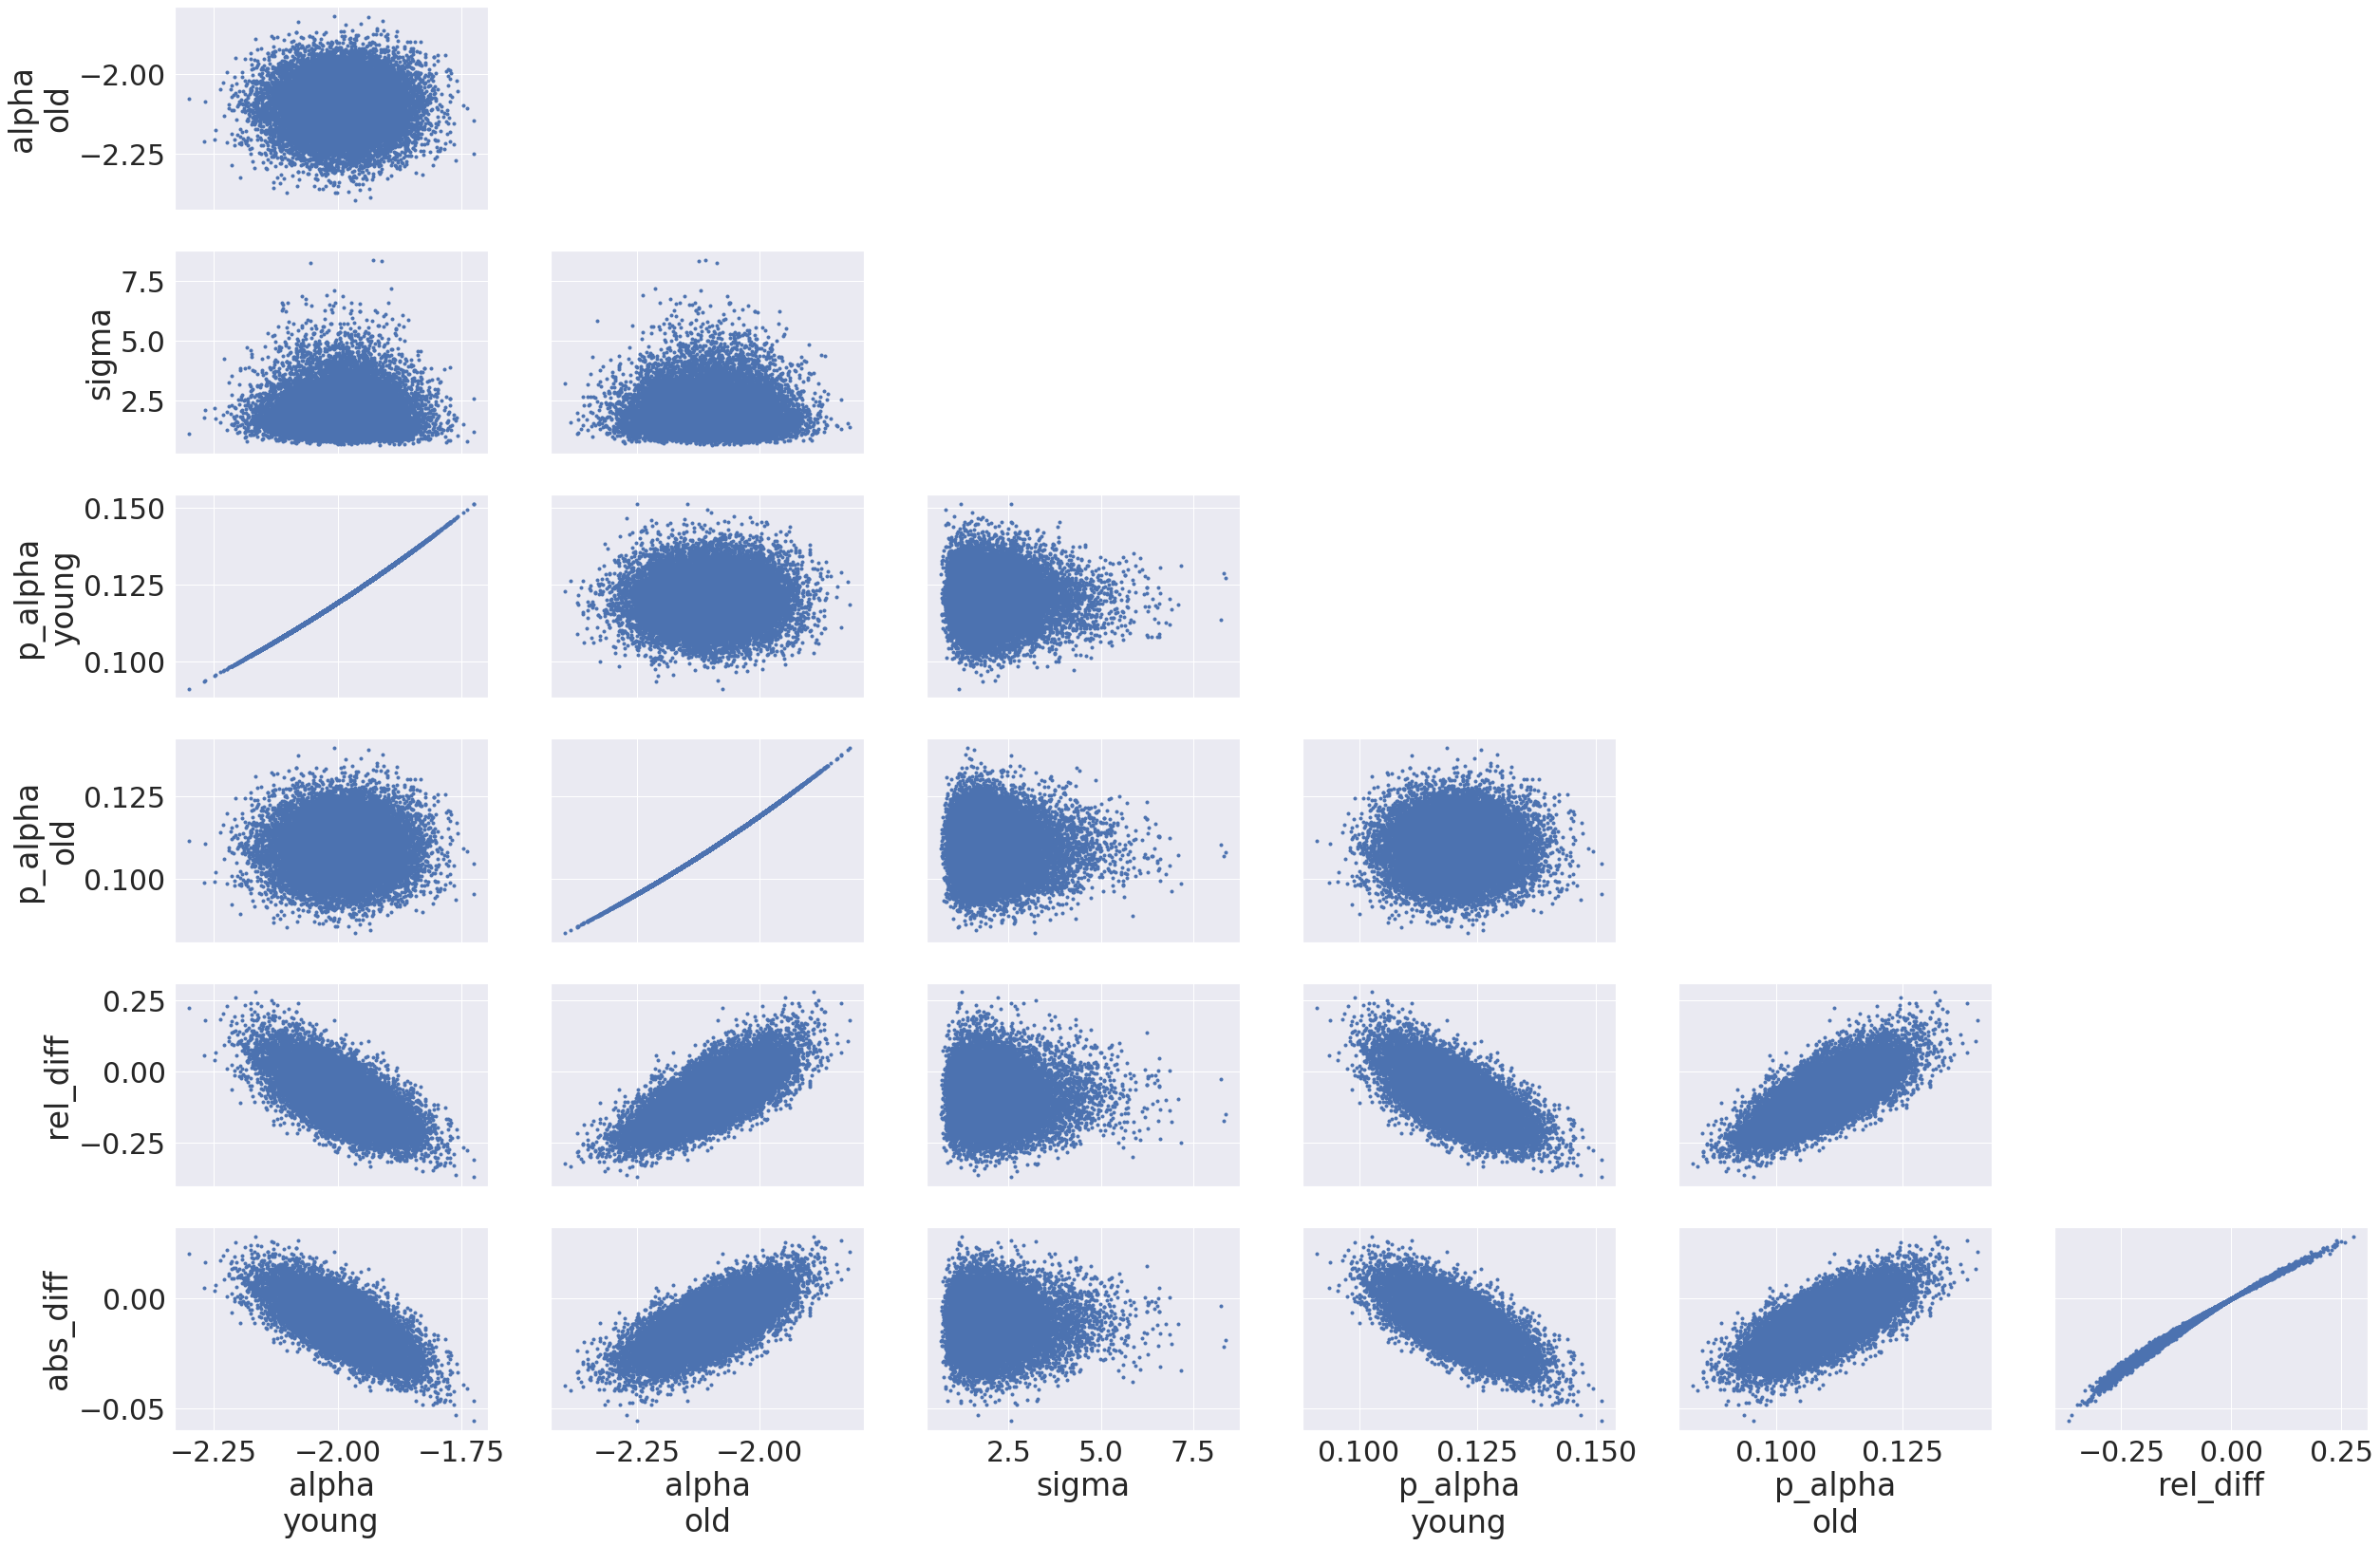

In [164]:
### perfect correlation between alpha and p_alpha ###
### would not want to use both as predictors in a linreg model ###

with a_b_full_pool_age:
    az.plot_pair(a_b_full_pool_idata,textsize=30)

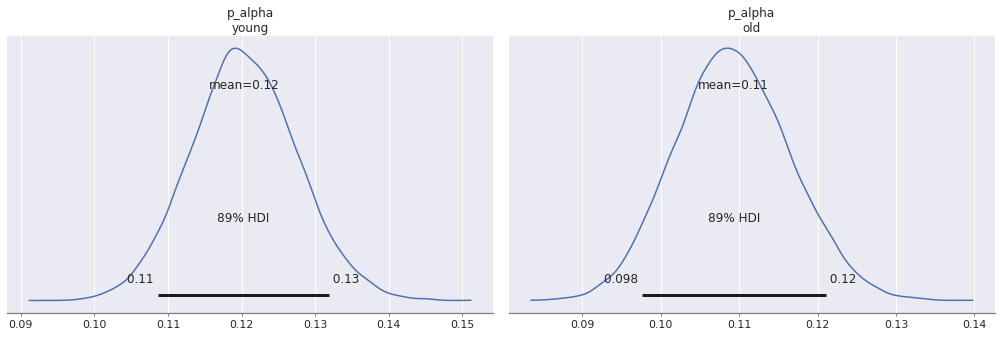

In [165]:
with a_b_full_pool_age:
    az.plot_posterior(a_b_full_pool_idata,var_names=['p_alpha'],hdi_prob=0.89)

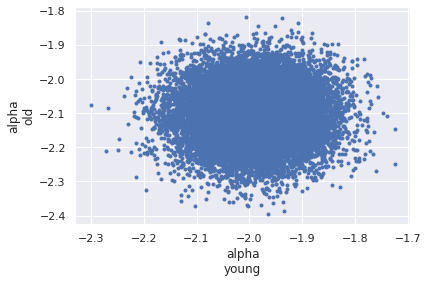

In [166]:
with a_b_full_pool_age:
    
    az.plot_pair(trace_a_b_full_pool_age,var_names=['alpha'])

0.12060301507537688


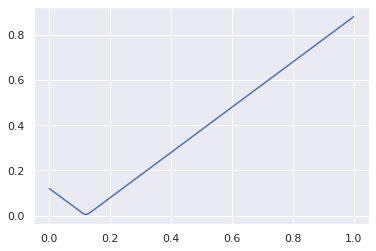

In [167]:
### loss function ###

grid = np.linspace(0,1,200)
p_alpha_pos = trace_a_b_full_pool_age['p_alpha'][:,0]
loss_f = [np.mean(abs(i - p_alpha_pos)) for i in grid]
mini = grid[np.argmin(loss_f)]
plt.plot(grid,loss_f)
print (mini)


In [168]:
post_pred_check = pm.sample_posterior_predictive(trace_a_b_full_pool_age,model=a_b_full_pool_age,
                                                 var_names=['obs','p_alpha'])

In [169]:
post_pred_check['obs'].shape

(20000, 8)

In [170]:
### mean posterior sample conversions for each of the 8 cohorts ###
post_pred_check['obs'].mean(axis=0)

array([58.3603 , 12.7153 , 32.56395, 68.912  , 55.61505, 99.86745,
       96.08495, 16.29495])

In [171]:
coords

{'age': ['young', 'old']}

In [172]:
from_pm = az.from_pymc3(posterior_predictive=post_pred_check,model=a_b_full_pool_age,coords=coords)
from_pm

Inference data with groups:
	> posterior_predictive
	> observed_data

<AxesSubplot:xlabel='obs'>

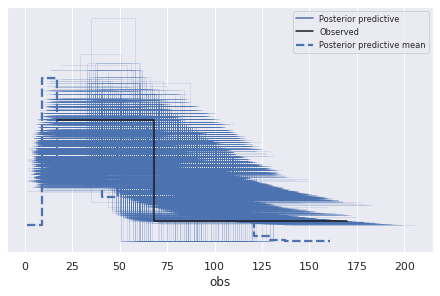

In [173]:
az.plot_ppc(from_pm,var_names=['obs'])

In [174]:
np.percentile(post_pred_check['obs'][:,0],[5.5,94.5])

array([46., 71.])

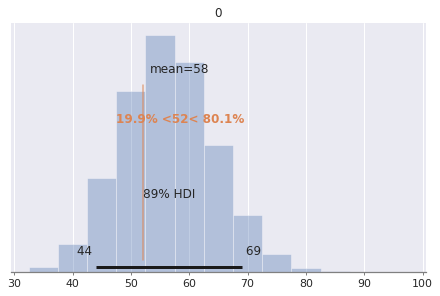

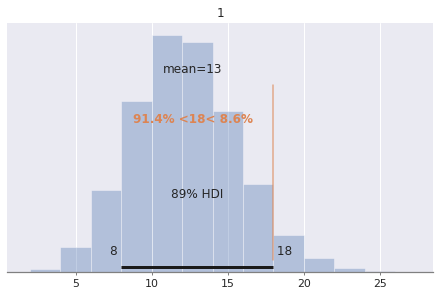

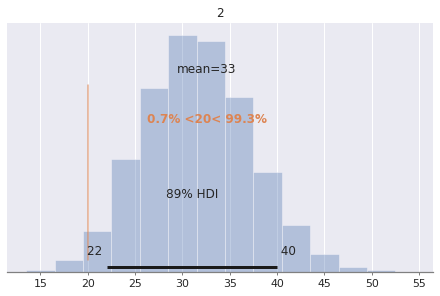

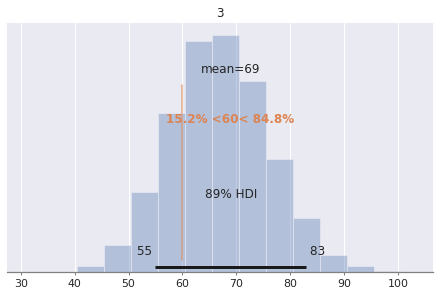

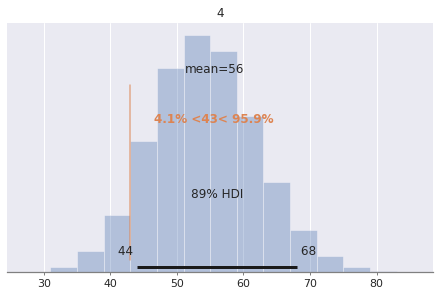

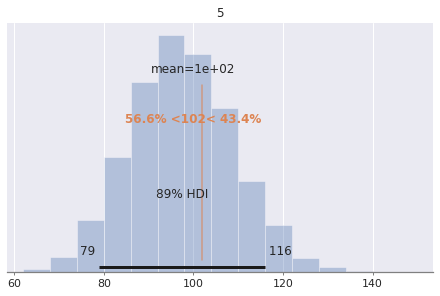

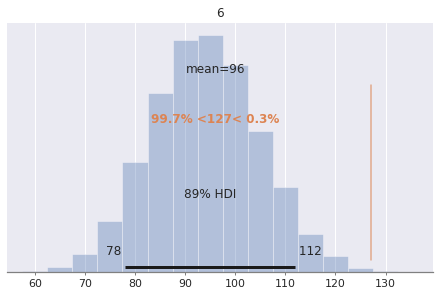

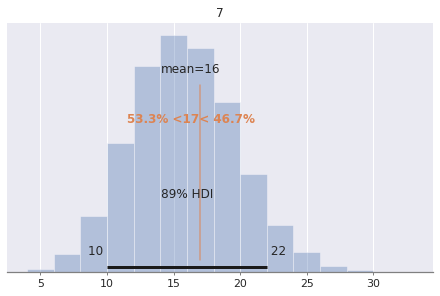

In [175]:
### poor man's plot_ppc (since I can't get plot_ppc working ok with coords on obs ###
sample_conversions = combined_df['sample_conversions'].values

for i in range(8):
    
    ax = az.plot_posterior(post_pred_check['obs'][:,i],hdi_prob=0.89,ref_val=sample_conversions[i])
    ax.set_title(i)

In [176]:
combined_df

,country,pop,pop_conversions,age_idx,pop_conversion_rate,country_idx,sample_conversions,sample_size,sample_conversion_rate
cohort#,,,,,,,,,
0,SWE,100000,11993,0,0.11993,0,52.0,485.0,0.107216
1,SWE,100000,19426,1,0.19426,0,18.0,116.0,0.155172
2,FIN,100000,6970,0,0.06970,1,20.0,271.0,0.073801
3,FIN,100000,10339,1,0.10339,1,60.0,631.0,0.095087
4,DEN,100000,10066,0,0.10066,2,43.0,462.0,0.093074
5,DEN,100000,9246,1,0.09246,2,102.0,914.0,0.111597
6,NOR,100000,15379,0,0.15379,3,127.0,799.0,0.158949
7,NOR,100000,11354,1,0.11354,3,17.0,149.0,0.114094


/usr/local/lib64/python3.8/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


array([<AxesSubplot:title={'center':'89.0% HDI'}>], dtype=object)

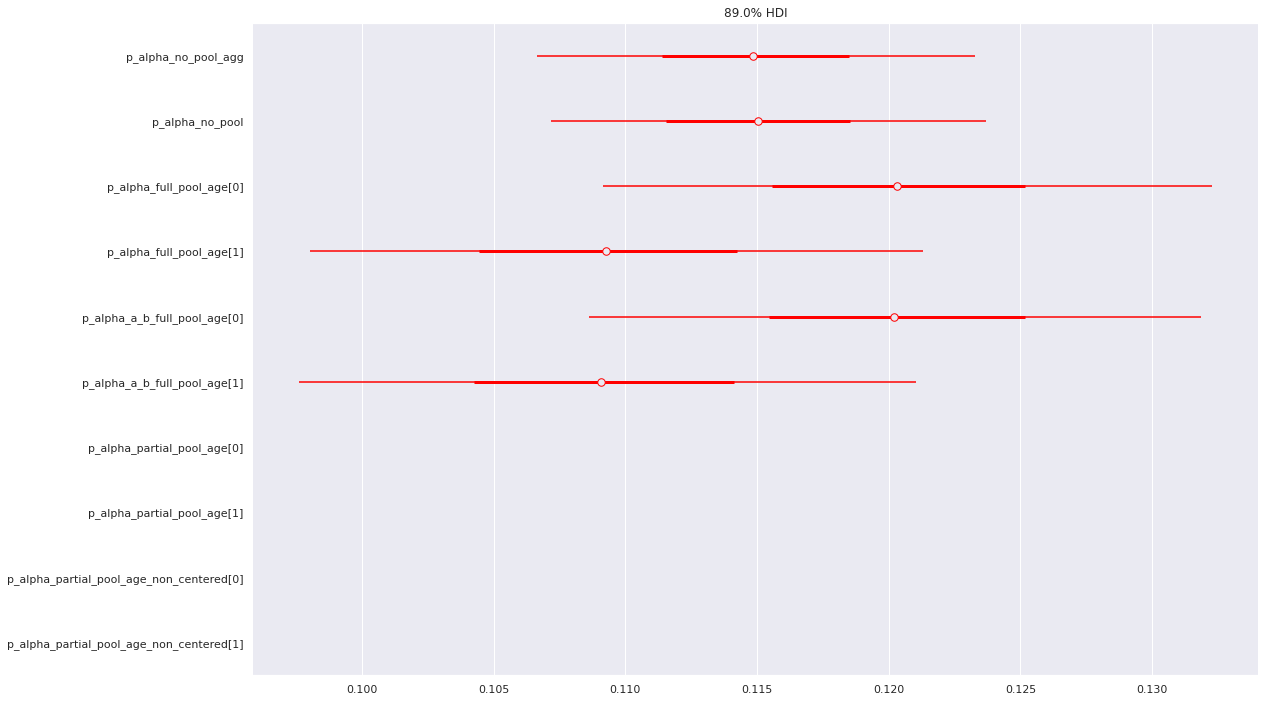

In [180]:
### forest plot with several models ###

### WHY DOES IT NOT PLOT THE LAST 4 .... ? ###
fig,ax = plt.subplots(figsize=(18,12))
az.plot_forest({'p_alpha_no_pool_agg' : trace_no_pool_agg_mdl['p_alpha'],
               'p_alpha_no_pool' : trace_no_pool_mdl['p_alpha'],
               'p_alpha_full_pool_age[0]' : trace_pooling_age_mdl['p_alpha'][:,0],
               'p_alpha_full_pool_age[1]' : trace_pooling_age_mdl['p_alpha'][:,1],
                'p_alpha_a_b_full_pool_age[0]' : trace_a_b_full_pool_age['p_alpha'][:,0],
                'p_alpha_a_b_full_pool_age[1]' : trace_a_b_full_pool_age['p_alpha'][:,1],
                'p_alpha_partial_pool_age[0]' : trace_partial_pooling_age_mdl['p_alpha'][:,0],
               'p_alpha_partial_pool_age[1]' : trace_partial_pooling_age_mdl['p_alpha'][:,1],
               'p_alpha_partial_pool_age_non_centered[0]' : trace_partial_pooling_age_mdl_non_centered['p_alpha'][:,0],
               'p_alpha_partial_pool_age_non_centered[1]' : trace_partial_pooling_age_mdl_non_centered['p_alpha'][:,1]},
               hdi_prob=0.89,ax=ax,colors=['red'],
              markersize=10)

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

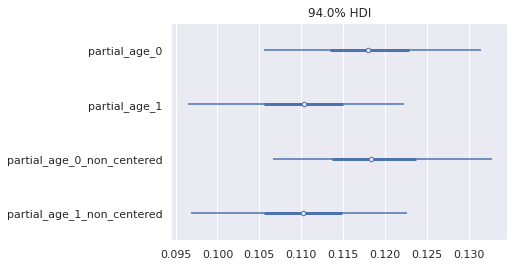

In [188]:
fig,ax = plt.subplots()

az.plot_forest({'partial_age_0' : trace_partial_pooling_age_mdl['p_alpha'][:,0],
               'partial_age_1' : trace_partial_pooling_age_mdl['p_alpha'][:,1],
               'partial_age_0_non_centered' : trace_partial_pooling_age_mdl_non_centered['p_alpha'][:,0],
               'partial_age_1_non_centered' : trace_partial_pooling_age_mdl_non_centered['p_alpha'][:,1]},ax=ax)